# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [2]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [3]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [4]:
df = pd.read_csv('../../../input/df_raw_test.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,Monetary Policy Rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index),Wheat (US$ per ton),Corn (US$ per ton),Soybean oil (US$ per ton),Crude oil (US$ per barrel)
Fecha,,,,,,,,,
2019-08-01,0.155238,2.50,10.783622,11.131211,5.748980,5.194315,4.959057,6.443189,4.003798
2019-09-01,0.151966,2.50,10.792065,11.125202,5.748917,5.165015,4.913953,6.462062,4.040550
2019-10-01,0.148757,2.50,10.795930,11.127057,5.747810,5.204847,4.978704,6.503629,3.988299
2019-11-01,0.145714,2.25,10.802030,11.109024,5.746721,5.274724,4.942720,6.529491,4.044437
2019-12-01,0.142886,2.25,10.813291,11.131899,5.744579,5.306730,4.950479,6.585121,4.092312


In [5]:
df_lags = pd.read_csv('../../../input/df_lags_test.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,Monetary Policy Rate_lag_1,Monetary Policy Rate_lag_2,Monetary Policy Rate_lag_3,Monetary Policy Rate_lag_4,Circulating Currency Seasonally Adjusted (mill S/)_lag_1,Circulating Currency Seasonally Adjusted (mill S/)_lag_2,Circulating Currency Seasonally Adjusted (mill S/)_lag_3,Circulating Currency Seasonally Adjusted (mill S/)_lag_4,Net International Reserves (mill $)_lag_1,...,Corn (US$ per ton)_lag_3,Corn (US$ per ton)_lag_4,Soybean oil (US$ per ton)_lag_1,Soybean oil (US$ per ton)_lag_2,Soybean oil (US$ per ton)_lag_3,Soybean oil (US$ per ton)_lag_4,Crude oil (US$ per barrel)_lag_1,Crude oil (US$ per barrel)_lag_2,Crude oil (US$ per barrel)_lag_3,Crude oil (US$ per barrel)_lag_4
Fecha,,,,,,,,,,,,,,,,,,,,,
2019-08-01,0.155238,2.75,2.75,2.75,2.75,10.775826,10.772159,10.761742,10.762972,11.108755,...,4.928328,4.861634,6.426634,6.420082,6.378261,6.419762,4.048862,4.001086,4.106295,4.156843
2019-09-01,0.151966,2.50,2.75,2.75,2.75,10.783622,10.775826,10.772159,10.761742,11.131211,...,5.083703,4.928328,6.443189,6.426634,6.420082,6.378261,4.003798,4.048862,4.001086,4.106295
2019-10-01,0.148757,2.50,2.50,2.75,2.75,10.792065,10.783622,10.775826,10.772159,11.125202,...,5.095125,5.083703,6.462062,6.443189,6.426634,6.420082,4.040550,4.003798,4.048862,4.001086
2019-11-01,0.145714,2.50,2.50,2.50,2.75,10.795930,10.792065,10.783622,10.775826,11.127057,...,4.959057,5.095125,6.503629,6.462062,6.443189,6.426634,3.988299,4.040550,4.003798,4.048862
2019-12-01,0.142886,2.25,2.50,2.50,2.50,10.802030,10.795930,10.792065,10.783622,11.109024,...,4.913953,4.959057,6.529491,6.503629,6.462062,6.443189,4.044437,3.988299,4.040550,4.003798


## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [6]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2019-01-01,1,0.189323
2019-02-01,2,0.189323
2019-03-01,3,0.189323
2019-04-01,4,0.189323
2019-05-01,5,0.189323
2019-06-01,6,0.189323
2019-07-01,7,0.189323
2019-08-01,8,0.189323
2019-09-01,9,0.189323


In [7]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Horizon,Predicted,Actual
Fecha,,,
2019-01-01,1,0.189323,0.183777
2019-02-01,2,0.189323,0.176969
2019-03-01,3,0.189323,0.172253
2019-04-01,4,0.189323,0.168370
2019-05-01,5,0.189323,0.164934
2019-06-01,6,0.189323,0.161702
2019-07-01,7,0.189323,0.158490
2019-08-01,8,0.189323,0.155238
2019-09-01,9,0.189323,0.151966


In [8]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.005545,0.030174
2,0.009575,0.049990
3,0.012579,0.066358
4,0.015114,0.080880
5,0.017370,0.094278
6,0.019457,0.107034
7,0.021455,0.119535
8,0.023409,0.132038
9,0.025341,0.144681
10,0.027249,0.157483


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [9]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

In [10]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.183923,0.183777
2019-02-01,0.175837,0.176969
2019-03-01,0.165653,0.172253
2019-04-01,0.154025,0.168370
2019-05-01,0.141626,0.164934
2019-06-01,0.129116,0.161702
2019-07-01,0.117104,0.158490
2019-08-01,0.106121,0.155238
2019-09-01,0.096598,0.151966


In [11]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.000146,0.000794
2,0.000807,0.003596
3,0.003867,0.015169
4,0.007916,0.032677
5,0.012601,0.054405
6,0.017587,0.078924
7,0.022578,0.104952
8,0.027343,0.131383
9,0.031705,0.157268
10,0.035546,0.181813


### 3.1.3 Vector autoregression (VAR)

In [12]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2019-01-01']
test_set  = df[df.index >= '2019-01-01']

In [13]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(4)

In [15]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-4:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.140997,0.183777
2019-02-01,0.141147,0.176969
2019-03-01,0.143487,0.172253
2019-04-01,0.147491,0.168370
2019-05-01,0.152153,0.164934
2019-06-01,0.156490,0.161702
2019-07-01,0.159900,0.158490
2019-08-01,0.162223,0.155238
2019-09-01,0.163655,0.151966


In [16]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.042780,0.232784
2,0.039455,0.217602
3,0.036244,0.200734
4,0.033079,0.181552
5,0.030134,0.160740
6,0.027590,0.139322
7,0.025549,0.120689
8,0.024026,0.111228
9,0.022985,0.107416
10,0.022371,0.107297


<Axes: >

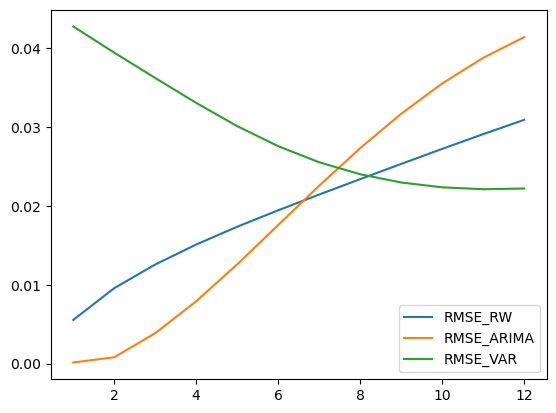

In [17]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [52]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.001, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [54]:
best_model

ElasticNet(l1_ratio=0)

In [55]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_ridge      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/h19_test/h19coef_ridge.xlsx' )

In [56]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
print(y_pred)

Fecha
2019-01-01    0.204814
2019-02-01    0.205048
2019-03-01    0.205020
2019-04-01    0.205189
2019-05-01    0.204573
2019-06-01    0.203571
2019-07-01    0.204108
2019-08-01    0.204509
2019-09-01    0.200507
2019-10-01    0.198023
2019-11-01    0.196684
2019-12-01    0.194223
dtype: float64


In [57]:
# And concatenate the results
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.204814,0.183777
2019-02-01,0.205048,0.176969
2019-03-01,0.205020,0.172253
2019-04-01,0.205189,0.168370
2019-05-01,0.204573,0.164934
2019-06-01,0.203571,0.161702
2019-07-01,0.204108,0.158490
2019-08-01,0.204509,0.155238
2019-09-01,0.200507,0.151966


In [58]:
RMSE_ridge, MAPE_ridge = get_metrics(results, 'Ridge')

<Axes: >

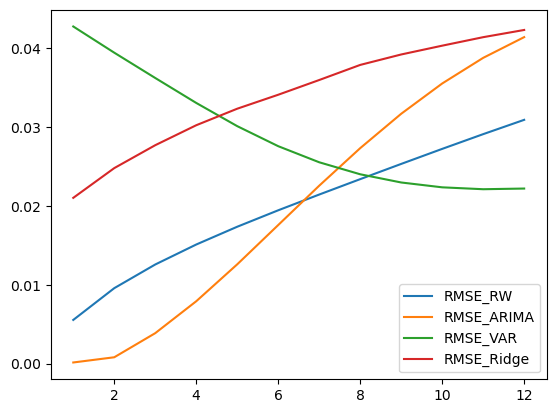

In [59]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [60]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
import sklearn.linear_model as skl
lasso = skl.ElasticNet( l1_ratio=1, random_state = 2024 )
model = lasso

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.001, 1, 1000)
grid_params = {'alpha': lambdas}

# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [61]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_lasso      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/h19_test/h19coef_lasso.xlsx' )

In [62]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [63]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.214671,0.183777
2019-02-01,0.214671,0.176969
2019-03-01,0.214671,0.172253
2019-04-01,0.214671,0.168370
2019-05-01,0.214671,0.164934
2019-06-01,0.214671,0.161702
2019-07-01,0.214671,0.158490
2019-08-01,0.214671,0.155238
2019-09-01,0.208969,0.151966


In [64]:
RMSE_lasso, MAPE_lasso = get_metrics(results, 'Lasso')

<Axes: >

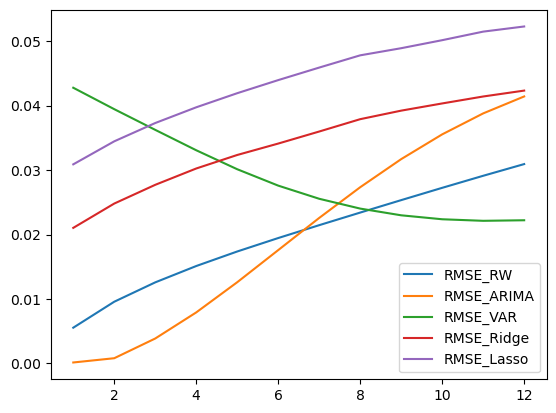

In [65]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [83]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# We define out lambdas and implement our gridparams
n_estimators = np.arange(5, 16)

#max_depth = np.arange(10, 51)

max_features = [None, 2/3, 1/3, "sqrt", "log2"]

grid_params = {'n_estimators': n_estimators, 'max_features': max_features}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [84]:
pred_vars = X_train.columns.to_list()
feature_importances = best_model.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/h19_test/h19coef_rf.xlsx' )

In [85]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [86]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.178058,0.183777
2019-02-01,0.182352,0.176969
2019-03-01,0.180509,0.172253
2019-04-01,0.192309,0.168370
2019-05-01,0.191204,0.164934
2019-06-01,0.186790,0.161702
2019-07-01,0.190081,0.158490
2019-08-01,0.197341,0.155238
2019-09-01,0.182251,0.151966


In [87]:
RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [88]:
RMSE_2019 = pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1)
MAPE_2019 = pd.concat([MAPE_rw, MAPE_arima, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1)

<Axes: >

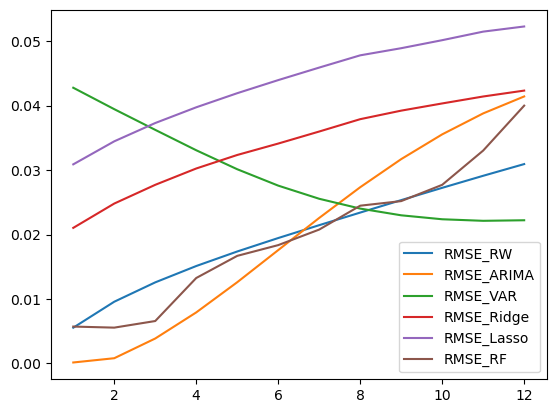

In [89]:
RMSE_2019.plot()

In [90]:
RMSE_2019_results = RMSE_2019.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2019_results = RMSE_2019_results.drop(columns=['RMSE_RW'])
RMSE_2019_results_highlight = RMSE_2019_results.style.apply(highlight_min, axis=1)
RMSE_2019_results_highlight

,RMSE_ARIMA,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,0.026318,7.714814,3.793582,5.571136,1.031353
2,0.084301,4.120624,2.590971,3.599583,0.579983
3,0.307419,2.881214,2.203299,2.965579,0.522974
4,0.523746,2.188597,2.001433,2.629692,0.877068
5,0.725436,1.734811,1.862222,2.414212,0.960947
6,0.903866,1.418002,1.753540,2.259659,0.943592
7,1.052381,1.190842,1.677362,2.139892,0.968192
8,1.168036,1.026364,1.619161,2.042391,1.045630
9,1.251128,0.907029,1.548010,1.930374,0.994000
10,1.304511,0.820976,1.480586,1.840859,1.017102


In [91]:
MAPE_2019_results = MAPE_2019.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2019_results = MAPE_2019_results.drop(columns=['MAPE_RW'])
MAPE_2019_results_highlight = MAPE_2019_results.style.apply(highlight_min, axis=1)
MAPE_2019_results_highlight

,MAPE_ARIMA,MAPE_VAR,MAPE_Ridge,MAPE_Lasso,MAPE_RF
1,0.026318,7.714814,3.793582,5.571136,1.031353
2,0.071930,4.352900,2.731834,3.812180,0.615466
3,0.228597,3.025009,2.327525,3.151541,0.549859
4,0.404020,2.244711,2.108161,2.789277,0.777825
5,0.577065,1.704947,1.956694,2.554022,0.871721
6,0.737370,1.301662,1.839443,2.384780,0.881449
7,0.878008,1.009660,1.755768,2.253963,0.914727
8,0.995036,0.842390,1.691282,2.147895,0.981352
9,1.086996,0.742431,1.617300,2.030471,0.949134
10,1.154492,0.681326,1.547548,1.935896,0.974286


In [92]:
tableH19 = RMSE_rw.join(RMSE_2019_results)
tableH19 = tableH19.rename(columns = {'RMSE_RW': 'Benchmark', 'RMSE_ARIMA': 'ARIMA', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 
                            'RMSE_Lasso': 'Lasso', 'RMSE_RF':'RF'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/h19_test/h19table_rmse.xlsx")

In [93]:
tableH19 = MAPE_rw.join(MAPE_2019_results)
tableH19 = tableH19.rename(columns = {'MAPE_RW': 'Benchmark', 'MAPE_ARIMA': 'ARIMA', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 
                            'MAPE_Lasso': 'Lasso', 'MAPE_RF':'RF'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/h19_test/h19table_mape.xlsx")

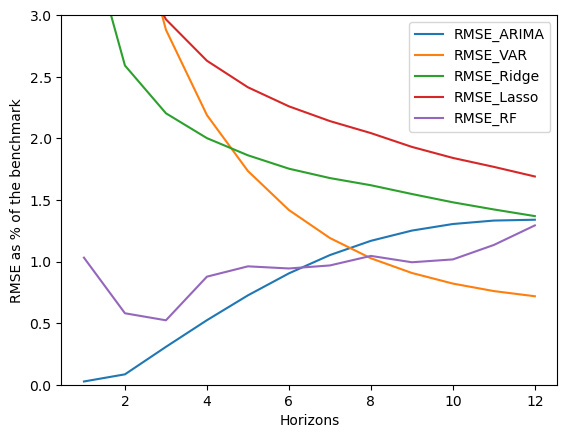

<Figure size 640x480 with 0 Axes>

In [94]:
graph_models(RMSE_2019_results, lim=3)

plt.savefig("../../../output/3_Regression/h19_test/h19_rmse.png", bbox_inches='tight', dpi=300)

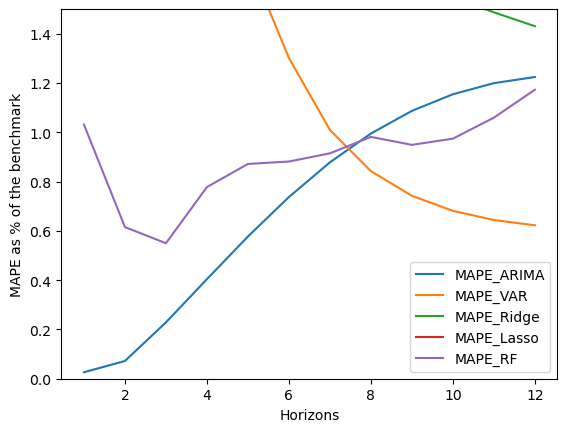

<Figure size 640x480 with 0 Axes>

In [95]:
graph_models(MAPE_2019_results, metric = "MAPE", lim=1.5)

plt.savefig("../../../output/3_Regression/h19_test/h19_mape.png", bbox_inches='tight', dpi=300)

### 3.3.2 Coefficients by model

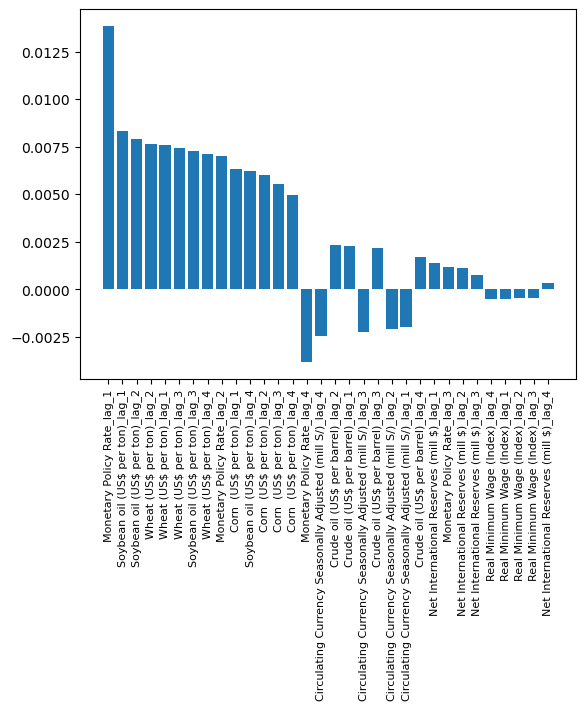

<Figure size 640x480 with 0 Axes>

In [96]:
graph_coefficients(vars_df_ridge, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_ridge.png", bbox_inches='tight', dpi=300)

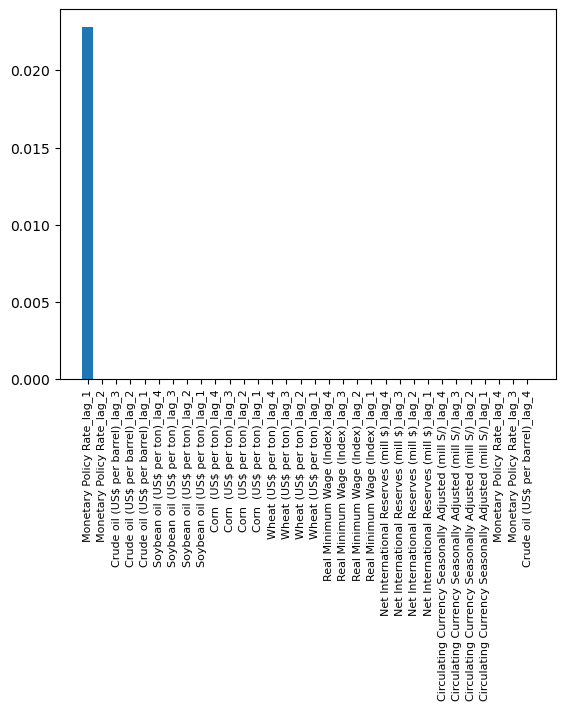

<Figure size 640x480 with 0 Axes>

In [97]:
graph_coefficients(vars_df_lasso, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_lasso.png", bbox_inches='tight', dpi=300)

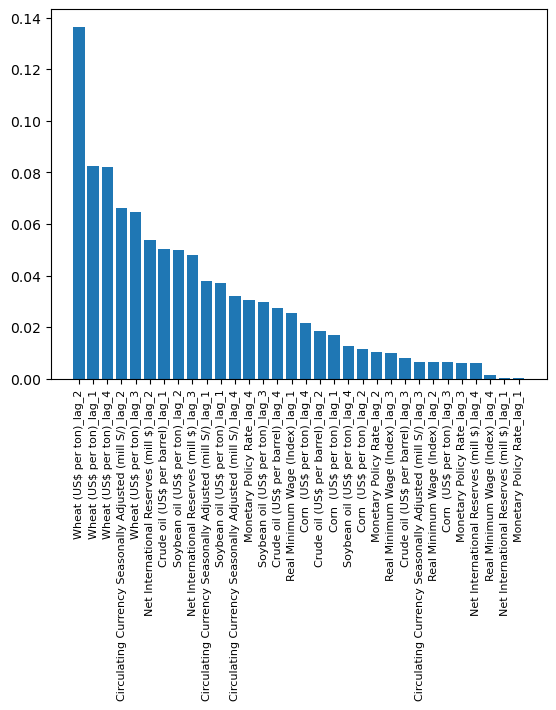

<Figure size 640x480 with 0 Axes>

In [98]:
graph_coefficients(vars_df_rf, value = "Importance Score")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_rf.png", bbox_inches='tight', dpi=300)